In [157]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn import svm
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import statsmodels.graphics.regressionplots as smg
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import RidgeCV
from tabulate import tabulate
from statsmodels.tools import add_constant

###Import training and validation data

In [122]:
train = pd.read_csv(r'C:\Users\abact\BC-Project\data\train_data.csv')
valid = pd.read_csv(r'C:\Users\abact\BC-Project\data\val_data.csv')
test = pd.read_csv(r'C:\Users\abact\BC-Project\data\test_data.csv')
# Convert variables to numeric in the train dataset
variables_to_convert = train.columns.drop('Date')
train[variables_to_convert] = train[variables_to_convert].apply(pd.to_numeric, errors='coerce')

# Convert variables to numeric in the valid dataset
valid[variables_to_convert] = valid[variables_to_convert].apply(pd.to_numeric, errors='coerce')

# Prepare the data for the model
X_train = train.drop(columns=['Difference', 'Increase', 'Decrease', 'Date'])
y_train = train['Difference']  # Use the 'Difference' variable as the target

X_valid = valid.drop(columns=['Difference', 'Increase', 'Decrease', 'Date'])
y_valid = valid['Difference']  # Use the 'Difference' variable as the target

possible_values = [-1.00, -0.75, -0.50, -0.25, 0.00, 0.25, 0.50, 0.75, 1.00]

def round_to_nearest(value, possible_values):
    return min(possible_values, key=lambda x: abs(x - value))

def calculate_accuracy(y_true, y_pred):
    correct_predictions = 0
    total_predictions = len(y_true)
    
    for true_val, pred_val in zip(y_true, y_pred):
        if true_val == pred_val:
            correct_predictions += 1
            
    accuracy = correct_predictions / total_predictions
    return accuracy

###Start with basic linear models

###Best Variable Selection

In [56]:
# Create a copy of the 'train' DataFrame
test_data = train.copy()

# Create an empty DataFrame to store the results
variable_selection_results = pd.DataFrame(columns=['Variable', 't-statistic', 'p-value'])

# Convert 'Date' column to numeric temporarily
test_data['Date_numeric'] = pd.to_numeric(test_data['Date'], errors='coerce')

# Iterate over each predictor variable in the 'test_data' dataset
for predictor_variable in test_data.columns:
    if predictor_variable != 'Difference' and predictor_variable != 'Date':
        # Convert predictor variable to numeric type
        test_data[predictor_variable] = pd.to_numeric(test_data[predictor_variable], errors='coerce')
        
        # Perform the t-test
        t_stat, p_value = stats.ttest_ind(test_data[predictor_variable], test_data['Difference'], nan_policy='omit')
        
        # Store the results in the DataFrame
        variable_selection_results = variable_selection_results.append({
            'Variable': predictor_variable,
            't-statistic': t_stat,
            'p-value': p_value
        }, ignore_index=True)

# Sort the results by p-value in ascending order
variable_selection_results = variable_selection_results.sort_values(by='p-value', ascending=True)

# Convert 'Date_numeric' back to a date
test_data['Date_numeric'] = pd.to_datetime(test_data['Date_numeric'], errors='coerce')

# Print the variable selection results
print(variable_selection_results)

C:\Users\abact\AppData\Local\Temp\ipykernel_9156\2593679913.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  variable_selection_results = variable_selection_results.append({
C:\Users\abact\AppData\Local\Temp\ipykernel_9156\2593679913.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  variable_selection_results = variable_selection_results.append({
C:\Users\abact\AppData\Local\Temp\ipykernel_9156\2593679913.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  variable_selection_results = variable_selection_results.append({
C:\Users\abact\AppData\Local\Temp\ipykernel_9156\2593679913.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

                            Variable t-statistic   p-value
3                                CPI   87.047291       0.0
25  Durable Goods Orders_RollingMean    86.84105       0.0
6               Durable Goods Orders   86.048734       0.0
14           Average Hourly Earnings   68.095082       0.0
5                       Retail Sales   55.912999       0.0
..                               ...         ...       ...
10                               LEI   -0.362377  0.717272
35                            attain    0.253871  0.799733
85                        surpassing   -0.089933  0.928388
86                        tremendous   -0.089933  0.928388
96                      Date_numeric          --        --

[97 rows x 3 columns]


C:\Users\abact\AppData\Local\Temp\ipykernel_9156\2593679913.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  variable_selection_results = variable_selection_results.append({
C:\Users\abact\AppData\Local\Temp\ipykernel_9156\2593679913.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  variable_selection_results = variable_selection_results.append({
C:\Users\abact\AppData\Local\Temp\ipykernel_9156\2593679913.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  variable_selection_results = variable_selection_results.append({
C:\Users\abact\AppData\Local\Temp\ipykernel_9156\2593679913.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

###Subset Selection

In [57]:
top_15_variable_names = variable_selection_results['Variable'].head(15)
top_15_variable_names

3                                  CPI
25    Durable Goods Orders_RollingMean
6                 Durable Goods Orders
14             Average Hourly Earnings
5                         Retail Sales
24            Retail Sales_RollingMean
4                    Unemployment Rate
8         Long-Term Treasury Bond Rate
19        Standardized Sentiment Score
2                                Level
7        Short-Term Treasury Bond Rate
70                                risk
17                  Negative Frequency
83                           suggested
31                            appeared
Name: Variable, dtype: object

In [125]:
# Add the selected independent variables to the model
X = sm.add_constant(train[top_15_variable_names])

# Fit the OLS model
model = sm.OLS(train['Difference'], X).fit()

# Print the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             Difference   R-squared:                       0.324
Model:                            OLS   Adj. R-squared:                  0.267
Method:                 Least Squares   F-statistic:                     5.604
Date:                Wed, 26 Jul 2023   Prob (F-statistic):           2.85e-09
Time:                        19:41:24   Log-Likelihood:                 73.258
No. Observations:                 191   AIC:                            -114.5
Df Residuals:                     175   BIC:                            -62.48
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

In [126]:
# Add the selected independent variables to the model
X = sm.add_constant(train[top_15_variable_names])

# Fit the OLS model
model = sm.OLS(train['Difference'], X).fit()

# Get the fitted values from the model for the training set
y_train_pred = model.fittedvalues

# Convert fitted values to the closest allowed values for the training set
y_train_pred = [round_to_nearest(pred, possible_values) for pred in y_train_pred]

# Make predictions on the validation set
X_valid = sm.add_constant(valid[top_15_variable_names])
y_valid_pred = model.predict(X_valid)

# Convert fitted values to the closest allowed values for the validation set
y_valid_pred = [round_to_nearest(pred, possible_values) for pred in y_valid_pred]

In [130]:
# Calculate Mean Squared Error (MSE) for training set
mse_train = mean_squared_error(y_train, y_train_pred)

# Calculate Mean Squared Error (MSE) for validation set
mse_valid = mean_squared_error(y_valid, y_valid_pred)

# Calculate Root Mean Squared Error (RMSE) for training set
rmse_train = np.sqrt(mse_train)

# Calculate Root Mean Squared Error (RMSE) for validation set
rmse_valid = np.sqrt(mse_valid)

# Calculate R-squared (R^2) for training set
r2_train = r2_score(y_train, y_train_pred)

# Calculate R-squared (R^2) for validation set
r2_valid = r2_score(y_valid, y_valid_pred)

# Calculate adjusted R-squared for training set
n_train = X_train.shape[0]
p_train = X_train.shape[1]
adj_r2_train = 1 - ((1 - r2_train) * (n_train - 1) / (n_train - p_train - 1))

# Calculate adjusted R-squared for validation set
n_valid = X_valid.shape[0]
p_valid = X_valid.shape[1]
adj_r2_valid = 1 - ((1 - r2_valid) * (n_valid - 1) / (n_valid - p_valid - 1))

# Calculate accuracy for training and validation sets
accuracy_train = calculate_accuracy(y_train, y_train_pred)
accuracy_valid = calculate_accuracy(y_valid, y_valid_pred)

# Prepare the data for the table
data = [
    ["MSE", mse_train, mse_valid],
    ["RMSE", rmse_train, rmse_valid],
    ["R^2", r2_train, r2_valid],
    ["Adjusted R^2", adj_r2_train, adj_r2_valid],
    ["Accuracy", accuracy_train, accuracy_valid],
]

# Prepare the headers for the table
headers = ["Metric", "Training Set", "Validation Set"]

# Display the table
table = tabulate(data, headers=headers, tablefmt="grid")
print(table)

+--------------+----------------+------------------+
| Metric       |   Training Set |   Validation Set |
+==============+================+==================+
| MSE          |      0.0301047 |        0.0885417 |
+--------------+----------------+------------------+
| RMSE         |      0.173507  |        0.29756   |
+--------------+----------------+------------------+
| R^2          |      0.252001  |       -0.36227   |
+--------------+----------------+------------------+
| Adjusted R^2 |     -0.480415  |       -3.47603   |
+--------------+----------------+------------------+
| Accuracy     |      0.675393  |        0.291667  |
+--------------+----------------+------------------+


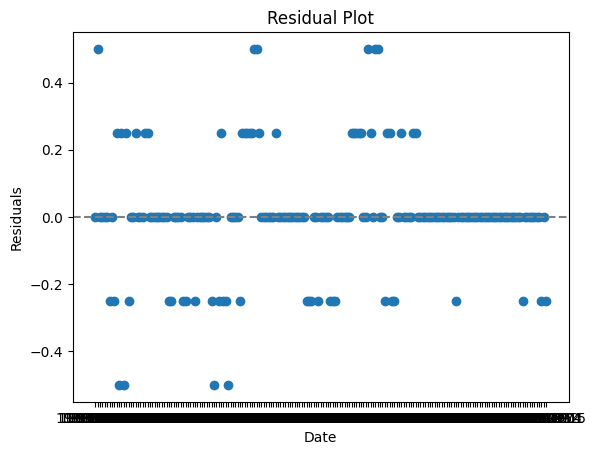

In [61]:
# Calculate the residual values between fitted_values_closest and the actual 'Difference' variable
residuals = y_train_pred - train['Difference']

# Create a DataFrame with 'Date' and residuals
residuals_df = pd.DataFrame({'Date': train['Date'], 'Residuals': residuals})

# Plot the residuals
fig, ax = plt.subplots()
ax.plot(residuals_df['Date'], residuals_df['Residuals'], marker='o', linestyle='None')
ax.axhline(y=0, color='gray', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Residuals')
ax.set_title('Residual Plot')
plt.show()

###All variables

In [131]:
#Redefine variables
train = pd.read_csv(r'C:\Users\abact\BC-Project\data\train_data.csv')
valid = pd.read_csv(r'C:\Users\abact\BC-Project\data\val_data.csv')
test = pd.read_csv(r'C:\Users\abact\BC-Project\data\test_data.csv')
# Convert variables to numeric in the train dataset
variables_to_convert = train.columns.drop('Date')
train[variables_to_convert] = train[variables_to_convert].apply(pd.to_numeric, errors='coerce')

# Convert variables to numeric in the valid dataset
valid[variables_to_convert] = valid[variables_to_convert].apply(pd.to_numeric, errors='coerce')

# Prepare the data for the model
X_train = train.drop(columns=['Difference', 'Increase', 'Decrease', 'Date'])
y_train = train['Difference']  # Use the 'Difference' variable as the target

X_valid = valid.drop(columns=['Difference', 'Increase', 'Decrease', 'Date'])
y_valid = valid['Difference']  # Use the 'Difference' variable as the target

In [132]:
# Add the selected independent variables to the model
X_train = sm.add_constant(X_train)  # Add constant for the intercept term
model = sm.OLS(y_train, X_train).fit()

# Get the fitted values from the model for the training set
y_train_pred = model.fittedvalues

# Convert fitted values to the closest allowed values for the training set
y_train_pred = [round_to_nearest(pred, possible_values) for pred in y_train_pred]

# Make predictions on the validation set
X_valid = sm.add_constant(X_valid)  # Add constant for the intercept term
y_valid_pred = model.predict(X_valid)

# Convert fitted values to the closest allowed values for the validation set
y_valid_pred = [round_to_nearest(pred, possible_values) for pred in y_valid_pred]

In [133]:
# Calculate Mean Squared Error (MSE) for training set
mse_train = mean_squared_error(y_train, y_train_pred)

# Calculate Mean Squared Error (MSE) for validation set
mse_valid = mean_squared_error(y_valid, y_valid_pred)

# Calculate Root Mean Squared Error (RMSE) for training set
rmse_train = np.sqrt(mse_train)

# Calculate Root Mean Squared Error (RMSE) for validation set
rmse_valid = np.sqrt(mse_valid)

# Calculate R-squared (R^2) for training set
r2_train = r2_score(y_train, y_train_pred)

# Calculate R-squared (R^2) for validation set
r2_valid = r2_score(y_valid, y_valid_pred)

# Calculate adjusted R-squared for training set
n_train = X_train.shape[0]
p_train = X_train.shape[1]
adj_r2_train = 1 - ((1 - r2_train) * (n_train - 1) / (n_train - p_train - 1))

# Calculate adjusted R-squared for validation set
n_valid = X_valid.shape[0]
p_valid = X_valid.shape[1]
adj_r2_valid = 1 - ((1 - r2_valid) * (n_valid - 1) / (n_valid - p_valid - 1))

# Calculate accuracy for training and validation sets
accuracy_train = calculate_accuracy(y_train, y_train_pred)
accuracy_valid = calculate_accuracy(y_valid, y_valid_pred)

# Prepare the data for the table
data = [
    ["MSE", mse_train, mse_valid],
    ["RMSE", rmse_train, rmse_valid],
    ["R^2", r2_train, r2_valid],
    ["Adjusted R^2", adj_r2_train, adj_r2_valid],
    ["Accuracy", accuracy_train, accuracy_valid],
]

# Prepare the headers for the table
headers = ["Metric", "Training Set", "Validation Set"]

# Display the table
table = tabulate(data, headers=headers, tablefmt="grid")
print(table)

+--------------+----------------+------------------+
| Metric       |   Training Set |   Validation Set |
+==============+================+==================+
| MSE          |     0.00458115 |         0.03125  |
+--------------+----------------+------------------+
| RMSE         |     0.0676842  |         0.176777 |
+--------------+----------------+------------------+
| R^2          |     0.886174   |         0.519199 |
+--------------+----------------+------------------+
| Adjusted R^2 |     0.772348   |         1.15359  |
+--------------+----------------+------------------+
| Accuracy     |     0.926702   |         0.5      |
+--------------+----------------+------------------+


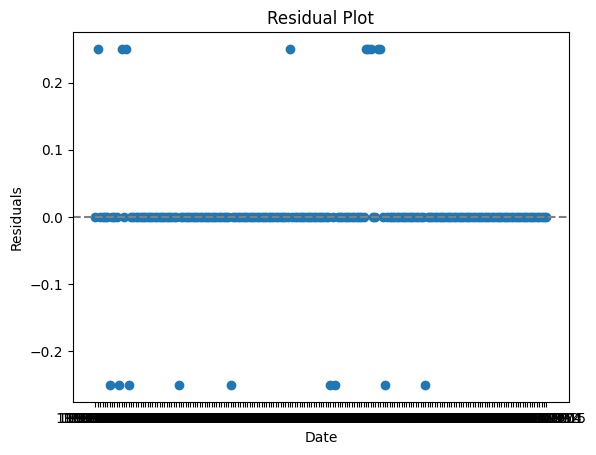

In [101]:
# Calculate the residual values between fitted_values_closest and the actual 'Difference' variable
residuals = y_train_pred - train['Difference']

# Create a DataFrame with 'Date' and residuals
residuals_df = pd.DataFrame({'Date': train['Date'], 'Residuals': residuals})

# Plot the residuals
fig, ax = plt.subplots()
ax.plot(residuals_df['Date'], residuals_df['Residuals'], marker='o', linestyle='None')
ax.axhline(y=0, color='gray', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Residuals')
ax.set_title('Residual Plot')
plt.show()

###Reverse Variable Selection (p-value)

In [134]:
def perform_reverse_variable_selection(X, y, threshold):
    model = sm.OLS(y, sm.add_constant(X)).fit()
    
    while True:
        p_values = model.pvalues[1:]  # Exclude the constant term
        
        # Find the predictor variable with the highest p-value
        max_p_value = p_values.max()
        if max_p_value <= threshold:
            break
        
        # Remove the predictor variable with the highest p-value
        max_p_var = p_values.idxmax()
        X = X.drop(max_p_var, axis=1)
        
        # Fit the model with the updated set of predictor variables
        model = sm.OLS(y, sm.add_constant(X)).fit()
    
    return model

# Perform reverse variable selection with a threshold of 0.05
threshold = 0.05
model_reverse_selection = perform_reverse_variable_selection(train[predictor_variables], train['Difference'], threshold)

# Print the summary of the linear regression results after variable selection
print(model_reverse_selection.summary())

                            OLS Regression Results                            
Dep. Variable:             Difference   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                     30.71
Date:                Wed, 26 Jul 2023   Prob (F-statistic):           1.74e-49
Time:                        19:42:28   Log-Likelihood:                 201.22
No. Observations:                 191   AIC:                            -350.4
Df Residuals:                     165   BIC:                            -265.9
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

In [136]:
# Extract the remaining variables in X_train after variable selection
selected_variables = model_reverse_selection.model.exog_names[1:]  # Exclude the constant term
X_train = train[selected_variables]

# Add the selected independent variables to the model
X_train = sm.add_constant(X_train)  # Add constant for the intercept term
model = sm.OLS(y_train, X_train).fit()

# Get the fitted values from the model for the training set
y_train_pred = model.fittedvalues

# Convert fitted values to the closest allowed values for the training set
y_train_pred = [round_to_nearest(pred, possible_values) for pred in y_train_pred]

# Make predictions on the validation set
X_valid = valid[selected_variables]  # Use the selected variables in the validation set
X_valid = sm.add_constant(X_valid)  # Add constant for the intercept term
y_valid_pred = model.predict(X_valid)

# Convert fitted values to the closest allowed values for the validation set
y_valid_pred = [round_to_nearest(pred, possible_values) for pred in y_valid_pred]

y_valid = valid['Difference']  # Use the 'Difference' variable as the target

In [137]:
# Calculate Mean Squared Error (MSE) for training set
mse_train = mean_squared_error(y_train, y_train_pred)

# Calculate Mean Squared Error (MSE) for validation set
mse_valid = mean_squared_error(y_valid, y_valid_pred)

# Calculate Root Mean Squared Error (RMSE) for training set
rmse_train = np.sqrt(mse_train)

# Calculate Root Mean Squared Error (RMSE) for validation set
rmse_valid = np.sqrt(mse_valid)

# Calculate R-squared (R^2) for training set
r2_train = r2_score(y_train, y_train_pred)

# Calculate R-squared (R^2) for validation set
r2_valid = r2_score(y_valid, y_valid_pred)

# Calculate adjusted R-squared for training set
n_train = X_train.shape[0]
p_train = X_train.shape[1]
adj_r2_train = 1 - ((1 - r2_train) * (n_train - 1) / (n_train - p_train - 1))

# Calculate adjusted R-squared for validation set
n_valid = X_valid.shape[0]
p_valid = X_valid.shape[1]
adj_r2_valid = 1 - ((1 - r2_valid) * (n_valid - 1) / (n_valid - p_valid - 1))

# Calculate accuracy for training and validation sets
accuracy_train = calculate_accuracy(y_train, y_train_pred)
accuracy_valid = calculate_accuracy(y_valid, y_valid_pred)

# Prepare the data for the table
data = [
    ["MSE", mse_train, mse_valid],
    ["RMSE", rmse_train, rmse_valid],
    ["R^2", r2_train, r2_valid],
    ["Adjusted R^2", adj_r2_train, adj_r2_valid],
    ["Accuracy", accuracy_train, accuracy_valid],
]

# Prepare the headers for the table
headers = ["Metric", "Training Set", "Validation Set"]

# Display the table
table = tabulate(data, headers=headers, tablefmt="grid")
print(table)

+--------------+----------------+------------------+
| Metric       |   Training Set |   Validation Set |
+==============+================+==================+
| MSE          |     0.00589005 |         0.03125  |
+--------------+----------------+------------------+
| RMSE         |     0.0767467  |         0.176777 |
+--------------+----------------+------------------+
| R^2          |     0.853652   |         0.519199 |
+--------------+----------------+------------------+
| Adjusted R^2 |     0.828358   |         3.21169  |
+--------------+----------------+------------------+
| Accuracy     |     0.905759   |         0.5      |
+--------------+----------------+------------------+


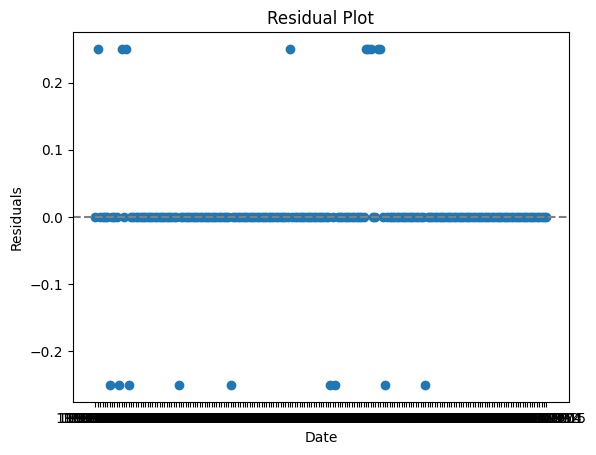

In [103]:
# Calculate the residual values between fitted_values_closest and the actual 'Difference' variable
residuals = y_train_pred - train['Difference']

# Create a DataFrame with 'Date' and residuals
residuals_df = pd.DataFrame({'Date': train['Date'], 'Residuals': residuals})

# Plot the residuals
fig, ax = plt.subplots()
ax.plot(residuals_df['Date'], residuals_df['Residuals'], marker='o', linestyle='None')
ax.axhline(y=0, color='gray', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Residuals')
ax.set_title('Residual Plot')
plt.show()

###Reverse variable selection (AICc) version

In [138]:
def perform_reverse_variable_selection_aicc(X, y):
    model = sm.OLS(y, sm.add_constant(X)).fit()
    n = len(y)
    k = X.shape[1] + 1  # Number of predictor variables + constant term
    aicc = model.aic + (2 * k * (k + 1)) / (n - k - 1)
    
    while True:
        aicc_values = []
        p_values = model.pvalues[1:]  # Exclude the constant term
        
        for var in X.columns:
            X_temp = X.drop(var, axis=1)
            model_temp = sm.OLS(y, sm.add_constant(X_temp)).fit()
            n_temp = len(y)
            k_temp = X_temp.shape[1] + 1
            aicc_temp = model_temp.aic + (2 * k_temp * (k_temp + 1)) / (n_temp - k_temp - 1)
            aicc_values.append(aicc_temp)
        
        min_aicc = np.min(aicc_values)
        if min_aicc < aicc:
            min_var_idx = np.argmin(aicc_values)
            X = X.drop(X.columns[min_var_idx], axis=1)
            aicc = min_aicc
            model = sm.OLS(y, sm.add_constant(X)).fit()
        else:
            break
    
    return model

# Perform reverse variable selection based on AICc
model_reverse_selection_aicc = perform_reverse_variable_selection_aicc(train[predictor_variables], train['Difference'])

# Print the summary of the linear regression results after variable selection
print(model_reverse_selection_aicc.summary())

                            OLS Regression Results                            
Dep. Variable:             Difference   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     31.07
Date:                Wed, 26 Jul 2023   Prob (F-statistic):           2.32e-50
Time:                        19:45:29   Log-Likelihood:                 205.72
No. Observations:                 191   AIC:                            -357.4
Df Residuals:                     164   BIC:                            -269.6
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

In [139]:
# Extract the remaining variables in X_train after variable selection based on AICc
selected_variables = model_reverse_selection_aicc.model.exog_names[1:]  # Exclude the constant term
X_train = train[selected_variables]
y_train = train['Difference']  # Use the 'Difference' variable as the target

# Add the constant term for the intercept (if needed)
X_train = sm.add_constant(X_train)

# Initialize and fit the Ridge Regression model with the selected variables
ridge_alpha = 1.0  # The regularization strength (alpha parameter)
ridge_model = Ridge(alpha=ridge_alpha)
ridge_model.fit(X_train, y_train)

# Get the fitted values from the model for the training set
y_train_pred = ridge_model.predict(X_train)

# Convert fitted values to the closest allowed values for the training set
y_train_pred = [round_to_nearest(pred, possible_values) for pred in y_train_pred]

# Make predictions on the validation set
X_valid = valid[selected_variables]  # Use the selected variables in the validation set
X_valid = sm.add_constant(X_valid)  # Add constant for the intercept term
y_valid_pred = ridge_model.predict(X_valid)

# Convert fitted values to the closest allowed values for the validation set
y_valid_pred = [round_to_nearest(pred, possible_values) for pred in y_valid_pred]

y_valid = valid['Difference']  # Use the 'Difference' variable as the target

In [140]:
# Calculate Mean Squared Error (MSE) for training set
mse_train = mean_squared_error(y_train, y_train_pred)

# Calculate Mean Squared Error (MSE) for validation set
mse_valid = mean_squared_error(y_valid, y_valid_pred)

# Calculate Root Mean Squared Error (RMSE) for training set
rmse_train = np.sqrt(mse_train)

# Calculate Root Mean Squared Error (RMSE) for validation set
rmse_valid = np.sqrt(mse_valid)

# Calculate R-squared (R^2) for training set
r2_train = r2_score(y_train, y_train_pred)

# Calculate R-squared (R^2) for validation set
r2_valid = r2_score(y_valid, y_valid_pred)

# Calculate adjusted R-squared for training set
n_train = X_train.shape[0]
p_train = X_train.shape[1]
adj_r2_train = 1 - ((1 - r2_train) * (n_train - 1) / (n_train - p_train - 1))

# Calculate adjusted R-squared for validation set
n_valid = X_valid.shape[0]
p_valid = X_valid.shape[1]
adj_r2_valid = 1 - ((1 - r2_valid) * (n_valid - 1) / (n_valid - p_valid - 1))

# Calculate accuracy for training and validation sets
accuracy_train = calculate_accuracy(y_train, y_train_pred)
accuracy_valid = calculate_accuracy(y_valid, y_valid_pred)

# Prepare the data for the table
data = [
    ["MSE", mse_train, mse_valid],
    ["RMSE", rmse_train, rmse_valid],
    ["R^2", r2_train, r2_valid],
    ["Adjusted R^2", adj_r2_train, adj_r2_valid],
    ["Accuracy", accuracy_train, accuracy_valid],
]

# Prepare the headers for the table
headers = ["Metric", "Training Set", "Validation Set"]

# Display the table
table = tabulate(data, headers=headers, tablefmt="grid")
print(table)

+--------------+----------------+------------------+
| Metric       |   Training Set |   Validation Set |
+==============+================+==================+
| MSE          |     0.00850785 |        0.0390625 |
+--------------+----------------+------------------+
| RMSE         |     0.092238   |        0.197642  |
+--------------+----------------+------------------+
| R^2          |     0.788609   |        0.398998  |
+--------------+----------------+------------------+
| Adjusted R^2 |     0.753593   |        4.45576   |
+--------------+----------------+------------------+
| Accuracy     |     0.863874   |        0.5       |
+--------------+----------------+------------------+


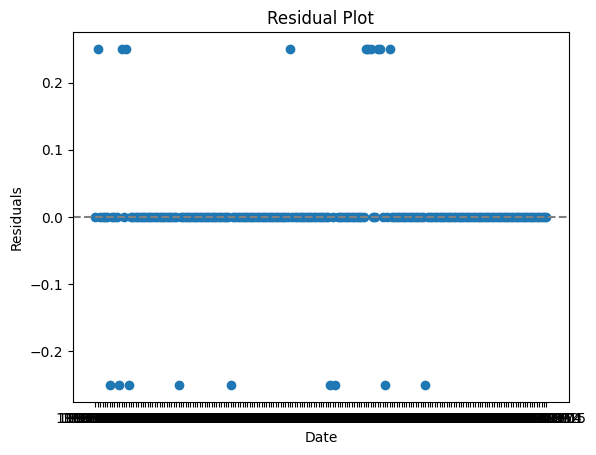

In [107]:
# Calculate the residual values between fitted_values_closest and the actual 'Difference' variable
residuals = y_train_pred - train['Difference']

# Create a DataFrame with 'Date' and residuals
residuals_df = pd.DataFrame({'Date': train['Date'], 'Residuals': residuals})

# Plot the residuals
fig, ax = plt.subplots()
ax.plot(residuals_df['Date'], residuals_df['Residuals'], marker='o', linestyle='None')
ax.axhline(y=0, color='gray', linestyle='--')
ax.set_xlabel('Date')
ax.set_ylabel('Residuals')
ax.set_title('Residual Plot')
plt.show()

###Ridge regression

In [141]:
# Initialize and fit the Ridge Regression model
ridge_alpha = 1.0  # The regularization strength (alpha parameter)
ridge_model = Ridge(alpha=ridge_alpha)
ridge_model.fit(X_train, y_train)

# Get the fitted values from the model for the training set
y_train_pred = ridge_model.predict(X_train)

# Convert fitted values to the closest allowed values for the training set
y_train_pred = [round_to_nearest(pred, possible_values) for pred in y_train_pred]

# Add the constant term for the intercept in X_valid
X_valid = sm.add_constant(X_valid)

# Make predictions on the validation set
y_valid_pred = ridge_model.predict(X_valid)

# Convert fitted values to the closest allowed values for the validation set
y_valid_pred = [round_to_nearest(pred, possible_values) for pred in y_valid_pred]

In [142]:
# Calculate Mean Squared Error (MSE) for training set
mse_train = mean_squared_error(y_train, y_train_pred)

# Calculate Mean Squared Error (MSE) for validation set
mse_valid = mean_squared_error(y_valid, y_valid_pred)

# Calculate Root Mean Squared Error (RMSE) for training set
rmse_train = np.sqrt(mse_train)

# Calculate Root Mean Squared Error (RMSE) for validation set
rmse_valid = np.sqrt(mse_valid)

# Calculate R-squared (R^2) for training set
r2_train = r2_score(y_train, y_train_pred)

# Calculate R-squared (R^2) for validation set
r2_valid = r2_score(y_valid, y_valid_pred)

# Calculate adjusted R-squared for training set
n_train = X_train.shape[0]
p_train = X_train.shape[1]
adj_r2_train = 1 - ((1 - r2_train) * (n_train - 1) / (n_train - p_train - 1))

# Calculate adjusted R-squared for validation set
n_valid = X_valid.shape[0]
p_valid = X_valid.shape[1]
adj_r2_valid = 1 - ((1 - r2_valid) * (n_valid - 1) / (n_valid - p_valid - 1))

# Calculate accuracy for training and validation sets
accuracy_train = calculate_accuracy(y_train, y_train_pred)
accuracy_valid = calculate_accuracy(y_valid, y_valid_pred)

# Prepare the data for the table
data = [
    ["MSE", mse_train, mse_valid],
    ["RMSE", rmse_train, rmse_valid],
    ["R^2", r2_train, r2_valid],
    ["Adjusted R^2", adj_r2_train, adj_r2_valid],
    ["Accuracy", accuracy_train, accuracy_valid],
]

# Prepare the headers for the table
headers = ["Metric", "Training Set", "Validation Set"]

# Display the table
table = tabulate(data, headers=headers, tablefmt="grid")
print(table)

+--------------+----------------+------------------+
| Metric       |   Training Set |   Validation Set |
+==============+================+==================+
| MSE          |     0.00850785 |        0.0390625 |
+--------------+----------------+------------------+
| RMSE         |     0.092238   |        0.197642  |
+--------------+----------------+------------------+
| R^2          |     0.788609   |        0.398998  |
+--------------+----------------+------------------+
| Adjusted R^2 |     0.753593   |        4.45576   |
+--------------+----------------+------------------+
| Accuracy     |     0.863874   |        0.5       |
+--------------+----------------+------------------+


In [167]:
train = pd.read_csv(r'C:\Users\abact\BC-Project\data\train_data.csv')
valid = pd.read_csv(r'C:\Users\abact\BC-Project\data\val_data.csv')
# Convert variables to numeric in the train dataset
variables_to_convert = train.columns.drop('Date')
train[variables_to_convert] = train[variables_to_convert].apply(pd.to_numeric, errors='coerce')

# Convert variables to numeric in the valid dataset
valid[variables_to_convert] = valid[variables_to_convert].apply(pd.to_numeric, errors='coerce')

# Prepare the data for the model
X_train = train.drop(columns=['Difference', 'Increase', 'Decrease', 'Date'])
y_train = train['Difference']  # Use the 'Difference' variable as the target

X_valid = valid.drop(columns=['Difference', 'Increase', 'Decrease', 'Date'])
y_valid = valid['Difference']  # Use the 'Difference' variable as the target

In [170]:
ridge = RidgeCV(cv=5)  # Set the number of cross-validation folds (e.g., 5)
ridge.fit(X_train_scaled, y_train)

# Get the best alpha chosen by RidgeCV
best_alpha = ridge.alpha_

# Fit the model with the best alpha to obtain the coefficients
ridge_best = Ridge(alpha=best_alpha)
ridge_best.fit(X_train_scaled, y_train)

# Add the constant term for the intercept in X_train
X_train_with_const = sm.add_constant(X_train)

# Add the constant term for the intercept in X_valid
X_valid_with_const = sm.add_constant(X_valid)

# Assuming 'selected_features' contains the list of best selected features
selected_X_train = X_train_with_const[selected_features]
selected_X_valid = X_valid_with_const[selected_features]

# Predict y_train_pred using the fitted Ridge model
y_train_pred = ridge_best.predict(selected_X_train)

# Convert fitted values to the closest allowed values for the training set
y_train_pred = [round_to_nearest(pred, possible_values) for pred in y_train_pred]

# Predict y_valid_pred using the fitted Ridge model
y_valid_pred = ridge_best.predict(selected_X_valid)

# Convert fitted values to the closest allowed values for the validation set
y_valid_pred = [round_to_nearest(pred, possible_values) for pred in y_valid_pred]

C:\ProgramData\anaconda3\lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(


ValueError: X has 16 features, but Ridge is expecting 96 features as input.

In [171]:
# Initialize and fit the Ridge Regression model
ridge_alpha = 5.0  # The regularization strength (alpha parameter)
ridge_model = Ridge(alpha=ridge_alpha)
ridge_model.fit(X_train, y_train)

# Get the fitted values from the model for the training set
y_train_pred = ridge_model.predict(X_train)

# Convert fitted values to the closest allowed values for the training set
y_train_pred = [round_to_nearest(pred, possible_values) for pred in y_train_pred]

# Add the constant term for the intercept in X_valid
X_valid = sm.add_constant(X_valid)

# Make predictions on the validation set
y_valid_pred = ridge_model.predict(X_valid)

# Convert fitted values to the closest allowed values for the validation set
y_valid_pred = [round_to_nearest(pred, possible_values) for pred in y_valid_pred]

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- const


In [145]:
# Calculate Mean Squared Error (MSE) for training set
mse_train = mean_squared_error(y_train, y_train_pred)

# Calculate Mean Squared Error (MSE) for validation set
mse_valid = mean_squared_error(y_valid, y_valid_pred)

# Calculate Root Mean Squared Error (RMSE) for training set
rmse_train = np.sqrt(mse_train)

# Calculate Root Mean Squared Error (RMSE) for validation set
rmse_valid = np.sqrt(mse_valid)

# Calculate R-squared (R^2) for training set
r2_train = r2_score(y_train, y_train_pred)

# Calculate R-squared (R^2) for validation set
r2_valid = r2_score(y_valid, y_valid_pred)

# Calculate adjusted R-squared for training set
n_train = X_train.shape[0]
p_train = X_train.shape[1]
adj_r2_train = 1 - ((1 - r2_train) * (n_train - 1) / (n_train - p_train - 1))

# Calculate adjusted R-squared for validation set
n_valid = X_valid.shape[0]
p_valid = X_valid.shape[1]
adj_r2_valid = 1 - ((1 - r2_valid) * (n_valid - 1) / (n_valid - p_valid - 1))

# Calculate accuracy for training and validation sets
accuracy_train = calculate_accuracy(y_train, y_train_pred)
accuracy_valid = calculate_accuracy(y_valid, y_valid_pred)

# Prepare the data for the table
data = [
    ["MSE", mse_train, mse_valid],
    ["RMSE", rmse_train, rmse_valid],
    ["R^2", r2_train, r2_valid],
    ["Adjusted R^2", adj_r2_train, adj_r2_valid],
    ["Accuracy", accuracy_train, accuracy_valid],
]

# Prepare the headers for the table
headers = ["Metric", "Training Set", "Validation Set"]

# Display the table
table = tabulate(data, headers=headers, tablefmt="grid")
print(table)

+--------------+----------------+------------------+
| Metric       |   Training Set |   Validation Set |
+==============+================+==================+
| MSE          |      0.0124346 |        0.0625    |
+--------------+----------------+------------------+
| RMSE         |      0.11151   |        0.25      |
+--------------+----------------+------------------+
| R^2          |      0.691044  |        0.0383973 |
+--------------+----------------+------------------+
| Adjusted R^2 |      0.639867  |        6.52922   |
+--------------+----------------+------------------+
| Accuracy     |      0.832461  |        0.375     |
+--------------+----------------+------------------+
